In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dill
import warnings

from sklearn.svm import LinearSVC, SVC
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from skfeature.function.similarity_based import fisher_score, reliefF
from skfeature.function.statistical_based import chi_square, f_score
from boruta import BorutaPy
from sklearn.feature_selection import RFE, SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')
%matplotlib inline
SEED=50

In [2]:
prostate = pd.read_csv('prostate.csv')
prostate.head()

,x.V1,x.V2,x.V3,x.V4,x.V5,x.V6,x.V7,x.V8,x.V9,x.V10,...,x.V12592,x.V12593,x.V12594,x.V12595,x.V12596,x.V12597,x.V12598,x.V12599,x.V12600,y
1,-9.0,1.0,1.0,15.0,-2.0,-3.0,4.0,8.0,-12.0,-12.0,...,5.0,3.0,21,15.0,1.0,0,14.0,-23.0,14.0,2
2,-2.0,1.0,1.0,4.0,-2.0,-5.0,0.0,8.0,-5.0,-9.0,...,3.0,2.0,12,7.0,4.0,5,4.0,-10.0,25.0,2
3,-6.0,17.0,6.0,29.0,4.0,-11.0,-8.0,10.0,-24.0,-32.0,...,-5.0,11.0,11,36.0,8.0,7,21.0,-82.0,10.0,2
4,0.0,9.0,4.0,19.0,-10.0,-18.0,-18.0,5.0,-33.0,-31.0,...,-7.0,6.0,9,22.0,3.0,20,-7.0,-62.0,24.0,2
5,-1.0,0.0,1.0,5.0,0.0,-4.0,1.0,6.0,-4.0,-9.0,...,6.0,1.0,140,10.0,3.0,8,8.0,-27.0,20.0,2


In [3]:
print(prostate.isnull().values.any())


False


In [4]:
features=prostate.iloc[:,0:-1]
labels=prostate.iloc[:,-1]

In [5]:
features.columns

Index(['x.V1', 'x.V2', 'x.V3', 'x.V4', 'x.V5', 'x.V6', 'x.V7', 'x.V8', 'x.V9',
       'x.V10',
       ...
       'x.V12591', 'x.V12592', 'x.V12593', 'x.V12594', 'x.V12595', 'x.V12596',
       'x.V12597', 'x.V12598', 'x.V12599', 'x.V12600'],
      dtype='object', length=12600)

In [6]:
# Crear lista con nombres variables
feature_labels = list(features.columns)

In [7]:
type(features)

pandas.core.frame.DataFrame

In [8]:
feature_labels[0:10]

['x.V1',
 'x.V2',
 'x.V3',
 'x.V4',
 'x.V5',
 'x.V6',
 'x.V7',
 'x.V8',
 'x.V9',
 'x.V10']

In [9]:
# Estandarizar

min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(features)

In [10]:
X

array([[0.75949367, 0.29577465, 0.43333333, ..., 0.34836066, 0.87700535,
        0.62698413],
       [0.84810127, 0.29577465, 0.43333333, ..., 0.30737705, 0.94652406,
        0.71428571],
       [0.79746835, 0.52112676, 0.6       , ..., 0.37704918, 0.56149733,
        0.5952381 ],
       ...,
       [0.82278481, 0.28169014, 0.4       , ..., 0.30327869, 0.96256684,
        0.70634921],
       [0.87341772, 0.30985915, 0.46666667, ..., 0.29918033, 1.        ,
        0.6984127 ],
       [0.84810127, 0.28169014, 0.4       , ..., 0.28278689, 0.95721925,
        0.66666667]])

In [11]:
Y = np.transpose(np.asarray(labels.values - 1, dtype=int))


In [12]:
Y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,stratify=labels,test_size=0.33, random_state=SEED)


In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((68, 12600), (34, 12600), (68,), (34,))

# 1. SVC

In [15]:
# Elegir SVC Lineal

clf_svc = SVC(kernel='linear', C=1, probability=True, random_state=SEED) 

In [16]:
%%time
clf_svc.fit(X_train, y_train)

CPU times: user 964 ms, sys: 20.4 ms, total: 985 ms
Wall time: 398 ms


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=50,
    shrinking=True, tol=0.001, verbose=False)

In [17]:
y_predict_svc = clf_svc.predict(X_test)
print ("Predicted Value:", y_predict_svc)

Predicted Value: [0 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1 0 1]


In [18]:
# Exactitud del modelo
print("Accuracy:",metrics.accuracy_score(y_test, y_predict_svc))

Accuracy: 0.8823529411764706


In [19]:
print(metrics.classification_report(y_test,y_predict_svc))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87        17
           1       0.84      0.94      0.89        17

    accuracy                           0.88        34
   macro avg       0.89      0.88      0.88        34
weighted avg       0.89      0.88      0.88        34



In [20]:
# Puntuacion ROC-AUC 
print("ROC-AUC:",metrics.roc_auc_score(y_test,clf_svc.predict_proba(X_test)[:,1]))

ROC-AUC: 0.958477508650519


# 2. NAIVE BAYES

In [21]:
# Crear clasificador Gaussiano

clf_nb = GaussianNB()

In [22]:
%%time
clf_nb.fit(X_train, y_train)

CPU times: user 34.1 ms, sys: 0 ns, total: 34.1 ms
Wall time: 11.8 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [23]:
#Predicciones

y_predict_nb = clf_nb.predict(X_test)
print ("Predicted Value:", y_predict_nb)

Predicted Value: [0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1]


In [24]:
# Exactitud

print("Accuracy:",metrics.accuracy_score(y_test, y_predict_nb))

Accuracy: 0.5588235294117647


In [25]:
print(metrics.classification_report(y_test,y_predict_nb))



              precision    recall  f1-score   support

           0       0.62      0.29      0.40        17
           1       0.54      0.82      0.65        17

    accuracy                           0.56        34
   macro avg       0.58      0.56      0.53        34
weighted avg       0.58      0.56      0.53        34



In [26]:
# Puntuacion ROC-AUC 
print("ROC-AUC:",metrics.roc_auc_score(y_test,clf_nb.predict_proba(X_test)[:,1]))

ROC-AUC: 0.5588235294117647


# 3. RANDOM FORESTS

In [27]:
# Crear clasificador

clf_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight='balanced', max_depth=5, random_state=SEED)



In [28]:
%%time
clf_rf.fit(X_train,y_train)



CPU times: user 634 ms, sys: 13.3 ms, total: 647 ms
Wall time: 143 ms


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=50, verbose=0, warm_start=False)

In [29]:
#Predicciones

y_predict_rf = clf_rf.predict(X_test)
print ("Predicted Value:", y_predict_rf)

Predicted Value: [0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 1 0 1 1 0 0 1 1 0 1]


In [30]:
# Exactitud

print("Accuracy:",metrics.accuracy_score(y_test, y_predict_rf))

Accuracy: 0.8823529411764706


In [31]:
print(metrics.classification_report(y_test,y_predict_rf))


              precision    recall  f1-score   support

           0       0.84      0.94      0.89        17
           1       0.93      0.82      0.87        17

    accuracy                           0.88        34
   macro avg       0.89      0.88      0.88        34
weighted avg       0.89      0.88      0.88        34



In [32]:
# Puntuacion ROC-AUC 
print("ROC-AUC:",metrics.roc_auc_score(y_test,clf_rf.predict_proba(X_test)[:,1]))

ROC-AUC: 0.9256055363321799


## SELECCIONAR VARIABLES USANDO PUNTUACION F

In [33]:
%%time
score_f = f_score.f_score(X_train, y_train)


CPU times: user 177 ms, sys: 506 µs, total: 178 ms
Wall time: 46 ms


In [34]:
score_f_df = pd.Series(score_f,index=features.columns.values).sort_values(ascending=False)


In [35]:
score_f_df.head(10)

x.V6185     58.725493
x.V8965     53.145762
x.V4365     48.352542
x.V5890     47.133673
x.V6866     45.704724
x.V10553    43.959030
x.V8850     41.763095
x.V12148    41.562857
x.V10494    38.848188
x.V10138    38.019471
dtype: float64

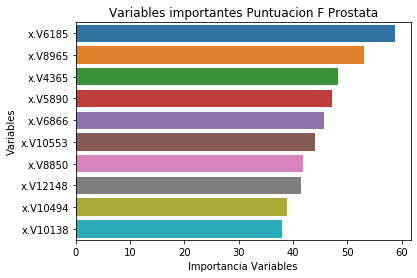

In [36]:
# Representacion grafica

sns.barplot(x=score_f_df[0:10,], y=score_f_df.index[0:10,])

plt.xlabel('Importancia Variables')
plt.ylabel('Variables')
plt.title("Variables importantes Puntuacion F Prostata")
plt.savefig("Variables Puntuacion F Prostata.pdf", dpi=300)
plt.show()

In [37]:
# Ordenar variables

idx_f = f_score.feature_ranking(score_f)
idx_f[0:10]

array([ 6184,  8964,  4364,  5889,  6865, 10552,  8849, 12147, 10493,
       10137])

In [38]:
# Especificar 10 variables

num_fea = 10
    
sel_f_train = X_train[:, idx_f[0:num_fea]]

sel_f_test = X_test[:, idx_f[0:num_fea]]

### Entrenar modelo con variables seleccionadas en conjunto de entrenamiento

In [39]:
%%time
clf_svc_fsc = clf_svc.fit(sel_f_train, y_train)

CPU times: user 1.19 ms, sys: 69 µs, total: 1.26 ms
Wall time: 1.02 ms


In [40]:
%%time
clf_nb_fsc = clf_nb.fit(sel_f_train, y_train)

CPU times: user 950 µs, sys: 55 µs, total: 1.01 ms
Wall time: 782 µs


In [41]:
%%time
clf_rf_fsc = clf_rf.fit(sel_f_train, y_train)

CPU times: user 71.8 ms, sys: 35.6 ms, total: 107 ms
Wall time: 131 ms


In [42]:
clf_svc_fsc.predict_proba(sel_f_test)

array([[8.82190369e-01, 1.17809631e-01],
       [9.45680630e-03, 9.90543194e-01],
       [7.77581647e-03, 9.92224184e-01],
       [7.72402018e-01, 2.27597982e-01],
       [4.15757967e-02, 9.58424203e-01],
       [7.86777206e-01, 2.13222794e-01],
       [2.70727533e-03, 9.97292725e-01],
       [7.15726809e-01, 2.84273191e-01],
       [7.98449426e-01, 2.01550574e-01],
       [7.77758677e-01, 2.22241323e-01],
       [9.81710320e-01, 1.82896804e-02],
       [8.81037856e-01, 1.18962144e-01],
       [6.01689917e-02, 9.39831008e-01],
       [9.16256728e-01, 8.37432717e-02],
       [8.68331875e-01, 1.31668125e-01],
       [9.62364406e-01, 3.76355939e-02],
       [4.36431298e-02, 9.56356870e-01],
       [6.65080938e-01, 3.34919062e-01],
       [8.03910262e-01, 1.96089738e-01],
       [2.15855232e-02, 9.78414477e-01],
       [6.48774154e-01, 3.51225846e-01],
       [2.03338963e-02, 9.79666104e-01],
       [2.74078236e-01, 7.25921764e-01],
       [5.72114066e-01, 4.27885934e-01],
       [2.662190

In [43]:
y_fsc_predict_rf = clf_rf_fsc.predict(sel_f_test)
y_fsc_predict_nb = clf_nb_fsc.predict(sel_f_test)
y_fsc_predict_svc = clf_svc_fsc.predict(sel_f_test)

In [44]:
# Exactitud

print("Accuracy F1 Score SVC:",metrics.accuracy_score(y_test, y_fsc_predict_svc))
print("Accuracy F1 Score NB:",metrics.accuracy_score(y_test, y_fsc_predict_nb))
print("Accuracy F1 Score RF:",metrics.accuracy_score(y_test, y_fsc_predict_rf))

Accuracy F1 Score SVC: 0.8823529411764706
Accuracy F1 Score NB: 0.8823529411764706
Accuracy F1 Score RF: 0.8823529411764706


In [45]:
# Puntuacion ROC-AUC 
print("ROC-AUC SVC:",metrics.roc_auc_score(y_test,clf_svc_fsc.predict_proba(sel_f_test)[:,1]))
print("ROC-AUC NB:",metrics.roc_auc_score(y_test,clf_nb_fsc.predict_proba(sel_f_test)[:,1]))
print("ROC-AUC RF:",metrics.roc_auc_score(y_test,clf_rf_fsc.predict_proba(sel_f_test)[:,1]))

ROC-AUC SVC: 0.9273356401384083
ROC-AUC NB: 0.9498269896193772
ROC-AUC RF: 0.9463667820069204


In [46]:
print(metrics.classification_report(y_test,y_fsc_predict_svc))
print(metrics.classification_report(y_test,y_fsc_predict_nb))
print(metrics.classification_report(y_test,y_fsc_predict_rf))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89        17
           1       0.93      0.82      0.87        17

    accuracy                           0.88        34
   macro avg       0.89      0.88      0.88        34
weighted avg       0.89      0.88      0.88        34

              precision    recall  f1-score   support

           0       0.84      0.94      0.89        17
           1       0.93      0.82      0.87        17

    accuracy                           0.88        34
   macro avg       0.89      0.88      0.88        34
weighted avg       0.89      0.88      0.88        34

              precision    recall  f1-score   support

           0       0.84      0.94      0.89        17
           1       0.93      0.82      0.87        17

    accuracy                           0.88        34
   macro avg       0.89      0.88      0.88        34
weighted avg       0.89      0.88      0.88        34



## SELECCIONAR VARIABLES USANDO CHI-CUADRADO

In [47]:
%%time
score_chi = chi_square.chi_square(X_train, y_train)

CPU times: user 134 ms, sys: 359 µs, total: 134 ms
Wall time: 34.8 ms


In [48]:
score_chi_df = pd.Series(score_chi,index=features.columns.values).sort_values(ascending=False)


In [49]:
score_chi_df.head(10)

x.V6185     6.465524
x.V10553    4.455327
x.V9850     4.392826
x.V288      4.327923
x.V6866     4.067919
x.V9172     3.974155
x.V5890     3.863846
x.V8850     3.819393
x.V10550    3.799247
x.V11052    3.616877
dtype: float64

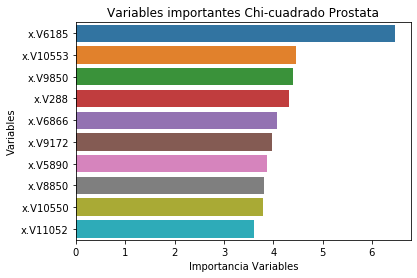

In [50]:
# Representacion grafica

sns.barplot(x=score_chi_df[0:10,], y=score_chi_df.index[0:10,])

plt.xlabel('Importancia Variables')
plt.ylabel('Variables')
plt.title("Variables importantes Chi-cuadrado Prostata")
plt.savefig("Variables importantes Chi-cuadrado Prostata.pdf", dpi=300)
plt.show()

In [51]:
# Ordenar variables

idx_chi = chi_square.feature_ranking(score_chi)
idx_chi[0:10]

array([ 6184, 10552,  9849,   287,  6865,  9171,  5889,  8849, 10549,
       11051])

In [52]:
# Especificar 10 variables

num_fea = 10
    
sel_chi_train = X_train[:, idx_chi[0:num_fea]]

sel_chi_test = X_test[:, idx_chi[0:num_fea]]


### Entrenar modelo con variables seleccionadas en conjunto de entrenamiento

In [53]:
%%time
clf_svc_chi = clf_svc.fit(sel_chi_train, y_train)

CPU times: user 1.22 ms, sys: 76 µs, total: 1.3 ms
Wall time: 884 µs


In [54]:
%%time
clf_nb_chi = clf_nb.fit(sel_chi_train, y_train)

CPU times: user 1.25 ms, sys: 0 ns, total: 1.25 ms
Wall time: 998 µs


In [55]:
%%time
clf_rf_chi = clf_rf.fit(sel_chi_train, y_train)

CPU times: user 69.8 ms, sys: 31.9 ms, total: 102 ms
Wall time: 133 ms


In [56]:
y_chi_predict_rf = clf_rf_chi.predict(sel_chi_test)
y_chi_predict_nb = clf_nb_chi.predict(sel_chi_test)
y_chi_predict_svc = clf_svc_chi.predict(sel_chi_test)

In [57]:
# Exactitud


print("Accuracy Chi-cuadrado SVC:",metrics.accuracy_score(y_test, y_chi_predict_svc))
print("Accuracy Chi-cuadrado NB:",metrics.accuracy_score(y_test, y_chi_predict_nb))
print("Accuracy Chi-cuadrado RF:",metrics.accuracy_score(y_test, y_chi_predict_rf))


Accuracy Chi-cuadrado SVC: 0.8823529411764706
Accuracy Chi-cuadrado NB: 0.8823529411764706
Accuracy Chi-cuadrado RF: 0.9411764705882353


In [58]:
# Puntuacion ROC-AUC 
print("ROC-AUC Chi-cuadrado SVC:",metrics.roc_auc_score(y_test,clf_svc_chi.predict_proba(sel_chi_test)[:,1]))
print("ROC-AUC Chi-cuadrado NB:",metrics.roc_auc_score(y_test,clf_nb_chi.predict_proba(sel_chi_test)[:,1]))
print("ROC-AUC Chi-cuadrado RF:",metrics.roc_auc_score(y_test,clf_rf_chi.predict_proba(sel_chi_test)[:,1]))

ROC-AUC Chi-cuadrado SVC: 0.8996539792387543
ROC-AUC Chi-cuadrado NB: 0.9238754325259515
ROC-AUC Chi-cuadrado RF: 0.944636678200692


In [59]:
print(metrics.classification_report(y_test,y_chi_predict_svc))
print(metrics.classification_report(y_test,y_chi_predict_nb))
print(metrics.classification_report(y_test,y_chi_predict_rf))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89        17
           1       0.93      0.82      0.87        17

    accuracy                           0.88        34
   macro avg       0.89      0.88      0.88        34
weighted avg       0.89      0.88      0.88        34

              precision    recall  f1-score   support

           0       0.84      0.94      0.89        17
           1       0.93      0.82      0.87        17

    accuracy                           0.88        34
   macro avg       0.89      0.88      0.88        34
weighted avg       0.89      0.88      0.88        34

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        17
           1       0.94      0.94      0.94        17

    accuracy                           0.94        34
   macro avg       0.94      0.94      0.94        34
weighted avg       0.94      0.94      0.94        34



## SELECCIONAR VARIABLES USANDO Fisher 

In [60]:
%%time
score_fisher = fisher_score.fisher_score(X_train, y_train)

CPU times: user 78.1 ms, sys: 11.4 ms, total: 89.4 ms
Wall time: 25 ms


In [61]:
score_fisher_df = pd.Series(score_fisher,index=features.columns.values).sort_values(ascending=False)


In [62]:
score_fisher_df.head(10)

x.V6185     0.889780
x.V8965     0.805239
x.V4365     0.732614
x.V5890     0.714147
x.V6866     0.692496
x.V10553    0.666046
x.V8850     0.632774
x.V12148    0.629740
x.V10494    0.588609
x.V10138    0.576053
dtype: float64

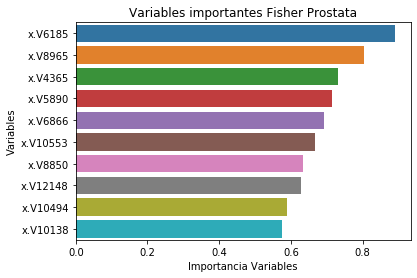

In [63]:
# Representacion grafica

sns.barplot(x=score_fisher_df[0:10,], y=score_fisher_df.index[0:10,])

plt.xlabel('Importancia Variables')
plt.ylabel('Variables')
plt.title("Variables importantes Fisher Prostata")
plt.savefig("Variables importantes Fisher Prostata.pdf", dpi=300)
plt.show()

In [64]:
# Ordenar variables

idx_fisher = fisher_score.feature_ranking(score_fisher)
idx_fisher[0:10]

array([ 6184,  8964,  4364,  5889,  6865, 10552,  8849, 12147, 10493,
       10137])

In [65]:
# Especificar 10 variables

num_fea = 10
    
sel_fisher_train = X_train[:, idx_fisher[0:num_fea]]

sel_fisher_test = X_test[:, idx_fisher[0:num_fea]]


### Entrenar modelo con variables seleccionadas en conjunto de entrenamiento

In [66]:
%%time
clf_svc_f = clf_svc.fit(sel_fisher_train, y_train)

CPU times: user 1.27 ms, sys: 81 µs, total: 1.35 ms
Wall time: 992 µs


In [67]:
%%time
clf_nb_f = clf_nb.fit(sel_fisher_train, y_train)

CPU times: user 1.44 ms, sys: 92 µs, total: 1.53 ms
Wall time: 1.28 ms


In [68]:
%%time
clf_rf_f = clf_rf.fit(sel_fisher_train, y_train)

CPU times: user 97.8 ms, sys: 8.38 ms, total: 106 ms
Wall time: 135 ms


In [69]:
y_fisher_predict_rf = clf_rf_f.predict(sel_fisher_test)
y_fisher_predict_nb = clf_nb_f.predict(sel_fisher_test)
y_fisher_predict_svc = clf_svc_f.predict(sel_fisher_test)

In [70]:
# Exactitud


print("Accuracy Fisher SVC:",metrics.accuracy_score(y_test, y_fisher_predict_svc))
print("Accuracy Fisher NB:",metrics.accuracy_score(y_test, y_fisher_predict_nb))
print("Accuracy Fisher RF:",metrics.accuracy_score(y_test, y_fisher_predict_rf))


Accuracy Fisher SVC: 0.8823529411764706
Accuracy Fisher NB: 0.8823529411764706
Accuracy Fisher RF: 0.8823529411764706


In [71]:
# Puntuacion ROC-AUC 
print("ROC-AUC Fisher SVC:",metrics.roc_auc_score(y_test,clf_svc_f.predict_proba(sel_fisher_test)[:,1]))
print("ROC-AUC Fisher NB:",metrics.roc_auc_score(y_test,clf_nb_f.predict_proba(sel_fisher_test)[:,1]))
print("ROC-AUC Fisher RF:",metrics.roc_auc_score(y_test,clf_rf_f.predict_proba(sel_fisher_test)[:,1]))

ROC-AUC Fisher SVC: 0.9273356401384083
ROC-AUC Fisher NB: 0.9498269896193772
ROC-AUC Fisher RF: 0.9463667820069204


In [72]:
print(metrics.classification_report(y_test,y_fisher_predict_svc))
print(metrics.classification_report(y_test,y_fisher_predict_nb))
print(metrics.classification_report(y_test,y_fisher_predict_rf))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89        17
           1       0.93      0.82      0.87        17

    accuracy                           0.88        34
   macro avg       0.89      0.88      0.88        34
weighted avg       0.89      0.88      0.88        34

              precision    recall  f1-score   support

           0       0.84      0.94      0.89        17
           1       0.93      0.82      0.87        17

    accuracy                           0.88        34
   macro avg       0.89      0.88      0.88        34
weighted avg       0.89      0.88      0.88        34

              precision    recall  f1-score   support

           0       0.84      0.94      0.89        17
           1       0.93      0.82      0.87        17

    accuracy                           0.88        34
   macro avg       0.89      0.88      0.88        34
weighted avg       0.89      0.88      0.88        34



## SELECCIONAR VARIABLES USANDO reliefF

In [73]:
%%time

score_relief = reliefF.reliefF(X_train, y_train, k=5)


CPU times: user 87.1 ms, sys: 0 ns, total: 87.1 ms
Wall time: 85.9 ms


In [74]:
score_relief

array([-0.87291139,  0.01577465, -0.25866667, ..., -0.66032787,
        1.2855615 , -0.03365079])

In [75]:
score_relief_df = pd.Series(score_relief,index=features.columns.values).sort_values(ascending=False)


In [76]:
score_relief_df.head(20)

x.V6185     11.179951
x.V5890     10.419048
x.V8729      8.871119
x.V9937      8.529167
x.V9850      8.358208
x.V10553     8.170963
x.V6866      7.873408
x.V9172      7.675283
x.V8850      7.600000
x.V9184      7.592568
x.V9034      7.527273
x.V8103      7.521994
x.V8965      7.466276
x.V10234     7.458667
x.V3794      7.392615
x.V205       7.375436
x.V9093      7.348426
x.V8443      7.213270
x.V9063      7.129577
x.V288       7.076846
dtype: float64

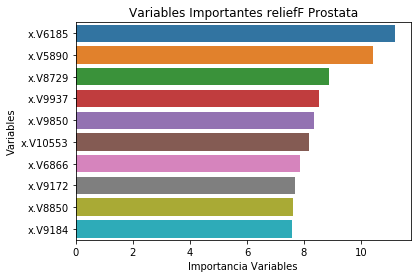

In [77]:
# Representar graficamente

sns.barplot(x=score_relief_df[0:10,], y=score_relief_df.index[0:10,])

plt.xlabel('Importancia Variables')
plt.ylabel('Variables')
plt.title("Variables Importantes reliefF Prostata")
plt.savefig("Variables importantes reliefF Prostata.pdf", dpi=300)

plt.show()

In [78]:
# Ordenar variables

idx_relief = reliefF.feature_ranking(score_relief)
idx_relief

array([ 6184,  5889,  8728, ...,  5481, 10942,  4246])

In [79]:
idx_relief.shape

(12600,)

### Entrenar modelo con variables seleccionadas en conjunto de entrenamiento

In [80]:
# Seleccionar 10:

num_fea = 10
    
sel_relief_train = X_train[:, idx_relief[0:num_fea]]

sel_relief_test = X_test[:, idx_relief[0:num_fea]]


In [81]:
sel_relief_train.shape

(68, 10)

In [82]:
%%time
clf_svc_rl = clf_svc.fit(sel_relief_train, y_train)

CPU times: user 1.32 ms, sys: 84 µs, total: 1.4 ms
Wall time: 1.13 ms


In [83]:
%%time
clf_nb_rl = clf_nb.fit(sel_relief_train, y_train)

CPU times: user 929 µs, sys: 0 ns, total: 929 µs
Wall time: 816 µs


In [84]:
%%time
clf_rf_rl = clf_rf.fit(sel_relief_train, y_train)

CPU times: user 85.1 ms, sys: 20.7 ms, total: 106 ms
Wall time: 131 ms


In [85]:
y_rl_predict_svc = clf_svc_rl.predict(sel_relief_test)
y_rl_predict_nb = clf_nb_rl.predict(sel_relief_test)
y_rl_predict_rf = clf_rf_rl.predict(sel_relief_test)

In [86]:
# Exactitud

print("Accuracy reliefF SVC:",metrics.accuracy_score(y_test, y_rl_predict_svc))
print("Accuracy reliefF NB:",metrics.accuracy_score(y_test, y_rl_predict_nb))
print("Accuracy reliefF RF:",metrics.accuracy_score(y_test, y_rl_predict_rf))

Accuracy reliefF SVC: 0.8529411764705882
Accuracy reliefF NB: 0.9117647058823529
Accuracy reliefF RF: 0.8823529411764706


In [87]:
# Puntuacion ROC-AUC 
print("ROC-AUC reliefF SVC:",metrics.roc_auc_score(y_test,clf_svc_rl.predict_proba(sel_relief_test)[:,1]))
print("ROC-AUC reliefF NB:",metrics.roc_auc_score(y_test,clf_nb_rl.predict_proba(sel_relief_test)[:,1]))
print("ROC-AUC reliefF RF:",metrics.roc_auc_score(y_test,clf_rf_rl.predict_proba(sel_relief_test)[:,1]))

ROC-AUC reliefF SVC: 0.944636678200692
ROC-AUC reliefF NB: 0.9480968858131488
ROC-AUC reliefF RF: 0.9550173010380623


In [88]:
# Metricas

print(metrics.classification_report(y_test,y_rl_predict_svc))
print(metrics.classification_report(y_test,y_rl_predict_nb))
print(metrics.classification_report(y_test,y_rl_predict_rf))

              precision    recall  f1-score   support

           0       0.80      0.94      0.86        17
           1       0.93      0.76      0.84        17

    accuracy                           0.85        34
   macro avg       0.86      0.85      0.85        34
weighted avg       0.86      0.85      0.85        34

              precision    recall  f1-score   support

           0       0.94      0.88      0.91        17
           1       0.89      0.94      0.91        17

    accuracy                           0.91        34
   macro avg       0.91      0.91      0.91        34
weighted avg       0.91      0.91      0.91        34

              precision    recall  f1-score   support

           0       0.84      0.94      0.89        17
           1       0.93      0.82      0.87        17

    accuracy                           0.88        34
   macro avg       0.89      0.88      0.88        34
weighted avg       0.89      0.88      0.88        34



## SELECCIONAR VARIABLES CON BORUTA

In [89]:
boruta_selector = BorutaPy(clf_rf, n_estimators='auto', verbose=0, random_state=SEED, max_iter = 100, perc = 100, alpha=1e-27)


In [90]:
%%time
boruta_selector.fit(X_train, y_train)

CPU times: user 16min 34s, sys: 2min 19s, total: 18min 54s
Wall time: 6min 46s


BorutaPy(alpha=1e-27,
         estimator=RandomForestClassifier(bootstrap=True,
                                          class_weight='balanced',
                                          criterion='gini', max_depth=5,
                                          max_features='auto',
                                          max_leaf_nodes=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=578, n_jobs=-1,
                                          oob_score=False,
                                          random_state=<mtrand.RandomState object at 0x7f956a587b88>,
                                          verbose=0, warm_start=False),
         max_iter

In [91]:
boruta_selector.n_features_

22

In [92]:
boruta_selector.support_

array([False, False, False, ..., False, False, False])

In [93]:
boruta_selector.ranking_


array([ 5887,  9889,  1051, ..., 10662, 11714,  1077])

In [94]:
score_boruta_df = pd.Series(boruta_selector.ranking_,index=features.columns.values).sort_values(ascending=True)
score_boruta_df.head(11)

x.V4365     1
x.V306      1
x.V8850     1
x.V299      1
x.V10956    1
x.V5890     1
x.V6185     1
x.V8965     1
x.V10138    1
x.V12148    1
x.V6865     1
dtype: int64

In [95]:
sel_boruta_train = boruta_selector.transform(X_train)

sel_boruta_test = boruta_selector.transform(X_test)

In [96]:
print(sel_boruta_train.shape)
print(sel_boruta_test.shape)

(68, 22)
(34, 22)


### Entrenar modelo con variables seleccionadas en conjunto de entrenamiento

In [97]:
%%time
clf_svc_b = clf_svc.fit(sel_boruta_train, y_train)

CPU times: user 2.51 ms, sys: 2.75 ms, total: 5.26 ms
Wall time: 1.27 ms


In [98]:
%%time
clf_nb_b = clf_nb.fit(sel_boruta_train, y_train)

CPU times: user 3.54 ms, sys: 496 µs, total: 4.04 ms
Wall time: 935 µs


In [99]:
%%time
clf_rf_b = clf_rf.fit(sel_boruta_train, y_train)

CPU times: user 724 ms, sys: 70.9 ms, total: 795 ms
Wall time: 469 ms


In [100]:
y_boruta_predict_svc = clf_svc_b.predict(sel_boruta_test)
y_boruta_predict_nb = clf_nb_b.predict(sel_boruta_test)
y_boruta_predict_rf = clf_rf_b.predict(sel_boruta_test)

In [101]:
print("Accuracy Boruta SVC:",metrics.accuracy_score(y_test, y_boruta_predict_svc))
print("Accuracy Boruta NB:",metrics.accuracy_score(y_test, y_boruta_predict_nb))
print("Accuracy Boruta RF:",metrics.accuracy_score(y_test, y_boruta_predict_rf))

Accuracy Boruta SVC: 0.9117647058823529
Accuracy Boruta NB: 0.9117647058823529
Accuracy Boruta RF: 0.9117647058823529


In [102]:
print(metrics.classification_report(y_test,y_boruta_predict_svc))
print(metrics.classification_report(y_test,y_boruta_predict_nb))
print(metrics.classification_report(y_test,y_boruta_predict_rf))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91        17
           1       0.94      0.88      0.91        17

    accuracy                           0.91        34
   macro avg       0.91      0.91      0.91        34
weighted avg       0.91      0.91      0.91        34

              precision    recall  f1-score   support

           0       0.89      0.94      0.91        17
           1       0.94      0.88      0.91        17

    accuracy                           0.91        34
   macro avg       0.91      0.91      0.91        34
weighted avg       0.91      0.91      0.91        34

              precision    recall  f1-score   support

           0       0.89      0.94      0.91        17
           1       0.94      0.88      0.91        17

    accuracy                           0.91        34
   macro avg       0.91      0.91      0.91        34
weighted avg       0.91      0.91      0.91        34



In [103]:
# Puntuacion ROC-AUC 
print("ROC-AUC Boruta SVC:",metrics.roc_auc_score(y_test,clf_svc_b.predict_proba(sel_boruta_test)[:,1]))
print("ROC-AUC Boruta NB:",metrics.roc_auc_score(y_test,clf_nb_b.predict_proba(sel_boruta_test)[:,1]))
print("ROC-AUC Boruta RF:",metrics.roc_auc_score(y_test,clf_rf_b.predict_proba(sel_boruta_test)[:,1]))

ROC-AUC Boruta SVC: 0.9619377162629758
ROC-AUC Boruta NB: 0.9619377162629758
ROC-AUC Boruta RF: 0.9653979238754326


## SELECCIONAR VARIABLES USANDO RFE (Eliminar recursivamente)

In [104]:
# RFE
rfe = RFE(estimator=clf_svc, n_features_to_select=10)



In [105]:
%%time
rfe = rfe.fit(X_train, y_train)
 


CPU times: user 2h 9min 53s, sys: 1min 36s, total: 2h 11min 29s
Wall time: 37min 47s


In [106]:
%%time

sel_rfe_train = rfe.transform(X_train)

sel_rfe_test = rfe.transform(X_test)

CPU times: user 2.66 ms, sys: 0 ns, total: 2.66 ms
Wall time: 1.43 ms


In [107]:
print(rfe.support_)
print(rfe.ranking_)

[False False False ... False False False]
[ 6368 11392   456 ... 12010  7728   384]


In [108]:
sel_rfe_train.shape

(68, 10)

### Entrenar modelo con variables seleccionadas en conjunto de entrenamiento

In [109]:
%%time
clf_svc_r = clf_svc.fit(sel_rfe_train, y_train)

CPU times: user 1.34 ms, sys: 0 ns, total: 1.34 ms
Wall time: 1.1 ms


In [110]:
%%time
clf_nb_r = clf_nb.fit(sel_rfe_train, y_train)

CPU times: user 834 µs, sys: 0 ns, total: 834 µs
Wall time: 742 µs


In [111]:
%%time
clf_rf_r = clf_rf.fit(sel_rfe_train, y_train)

CPU times: user 427 ms, sys: 113 ms, total: 540 ms
Wall time: 473 ms


In [112]:
y_rfe_predict_svc = clf_svc_r.predict(sel_rfe_test)
y_rfe_predict_nb = clf_nb_r.predict(sel_rfe_test)
y_rfe_predict_rf = clf_rf_r.predict(sel_rfe_test)


In [113]:
# Exactitud

print("Accuracy SVC:",metrics.accuracy_score(y_test, y_rfe_predict_svc))
print("Accuracy NB:",metrics.accuracy_score(y_test, y_rfe_predict_nb))
print("Accuracy RF:",metrics.accuracy_score(y_test, y_rfe_predict_rf))

Accuracy SVC: 0.8529411764705882
Accuracy NB: 0.9411764705882353
Accuracy RF: 0.8529411764705882


In [114]:
# Puntuacion ROC-AUC 
print("ROC-AUC RFE SVC:",metrics.roc_auc_score(y_test,clf_svc_r.predict_proba(sel_rfe_test)[:,1]))
print("ROC-AUC RFE NB:",metrics.roc_auc_score(y_test,clf_nb_r.predict_proba(sel_rfe_test)[:,1]))
print("ROC-AUC RFE RF:",metrics.roc_auc_score(y_test,clf_rf_r.predict_proba(sel_rfe_test)[:,1]))

ROC-AUC RFE SVC: 0.958477508650519
ROC-AUC RFE NB: 0.9411764705882353
ROC-AUC RFE RF: 0.9584775086505191


In [115]:
print(metrics.classification_report(y_test,y_rfe_predict_svc))
print(metrics.classification_report(y_test,y_rfe_predict_nb))
print(metrics.classification_report(y_test,y_rfe_predict_rf))



              precision    recall  f1-score   support

           0       0.83      0.88      0.86        17
           1       0.88      0.82      0.85        17

    accuracy                           0.85        34
   macro avg       0.85      0.85      0.85        34
weighted avg       0.85      0.85      0.85        34

              precision    recall  f1-score   support

           0       0.89      1.00      0.94        17
           1       1.00      0.88      0.94        17

    accuracy                           0.94        34
   macro avg       0.95      0.94      0.94        34
weighted avg       0.95      0.94      0.94        34

              precision    recall  f1-score   support

           0       0.83      0.88      0.86        17
           1       0.88      0.82      0.85        17

    accuracy                           0.85        34
   macro avg       0.85      0.85      0.85        34
weighted avg       0.85      0.85      0.85        34



In [116]:
pd.Series(rfe.ranking_,index=features.columns.values).sort_values(ascending=True).head(11)

x.V10215    1
x.V6185     1
x.V3333     1
x.V5890     1
x.V10553    1
x.V10234    1
x.V9034     1
x.V11858    1
x.V5661     1
x.V11137    1
x.V9157     2
dtype: int64

## SELECCIONAR VARIABLES USANDO SELECCION DE VARIABLES HACIA DELANTE

In [117]:
# Tarda mucho tiempo, incluso seleccionando solo 5 variables. Tiempos similares en Google collab.
sfs1 = sfs(clf_rf,
           k_features=10,
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy',
           n_jobs= -1,
           cv=0)



In [118]:
%%time
sfs1 = sfs1.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 28.0min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 28.2min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | elapsed: 32.4min
[Parallel(n_jobs=-1)]: Done 10352 tasks      | elapsed: 36.8min
[Parallel(n_jobs=-1)]: Done 11689 tasks      | elapsed: 41.6min
[Parallel(n_jobs=-1)]: Done 12594 out of 12594 | elapsed: 44.8min finished

[2019-11-09 19:10:07] Features: 7/10 -- score: 1.0[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      

CPU times: user 7h 24min 40s, sys: 2min 28s, total: 7h 27min 9s
Wall time: 7h 27min 25s



[2019-11-09 21:24:32] Features: 10/10 -- score: 1.0

In [119]:
# Mostrar variables seleccionadas

feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)

[0, 1, 2, 3, 4, 5, 6, 9, 22, 204]


In [120]:
sfs1.k_score_

1.0

### Entrenar modelo con variables seleccionadas en conjunto de entrenamiento

In [121]:
%%time
clf_svc_sfs = clf_svc.fit(X_train[:, feat_cols], y_train)

CPU times: user 1.52 ms, sys: 0 ns, total: 1.52 ms
Wall time: 1.3 ms


In [122]:
%%time
clf_rf_sfs = clf_rf.fit(X_train[:, feat_cols], y_train)

CPU times: user 473 ms, sys: 88.7 ms, total: 562 ms
Wall time: 463 ms


In [123]:
%%time
clf_nb_sfs = clf_nb.fit(X_train[:, feat_cols], y_train)

CPU times: user 4.11 ms, sys: 45 µs, total: 4.16 ms
Wall time: 2.86 ms


In [124]:
y_sfs_predict_svc = clf_svc_sfs.predict(X_test[:, feat_cols])
y_sfs_predict_nb = clf_nb_sfs.predict(X_test[:, feat_cols])
y_sfs_predict_rf = clf_rf_sfs.predict(X_test[:, feat_cols])

In [125]:
# Exactitud

print("Accuracy SVC:",metrics.accuracy_score(y_test, y_sfs_predict_svc))
print("Accuracy NB:",metrics.accuracy_score(y_test, y_sfs_predict_nb))
print("Accuracy RF:",metrics.accuracy_score(y_test, y_sfs_predict_rf))

Accuracy SVC: 0.6764705882352942
Accuracy NB: 0.5882352941176471
Accuracy RF: 0.7941176470588235


In [126]:
# Puntuacion ROC-AUC 
print("ROC-AUC SFS SVC:",metrics.roc_auc_score(y_test,clf_svc_sfs.predict_proba(X_test[:, feat_cols])[:,1]))
print("ROC-AUC SFS NB:",metrics.roc_auc_score(y_test,clf_nb_sfs.predict_proba(X_test[:, feat_cols])[:,1]))
print("ROC-AUC SFS RF:",metrics.roc_auc_score(y_test,clf_rf_sfs.predict_proba(X_test[:, feat_cols])[:,1]))

ROC-AUC SFS SVC: 0.8477508650519031
ROC-AUC SFS NB: 0.7370242214532873
ROC-AUC SFS RF: 0.8373702422145328


In [127]:
# Metricas

print(metrics.classification_report(y_test,y_sfs_predict_svc))
print(metrics.classification_report(y_test,y_sfs_predict_nb))
print(metrics.classification_report(y_test,y_sfs_predict_rf))

              precision    recall  f1-score   support

           0       0.88      0.41      0.56        17
           1       0.62      0.94      0.74        17

    accuracy                           0.68        34
   macro avg       0.75      0.68      0.65        34
weighted avg       0.75      0.68      0.65        34

              precision    recall  f1-score   support

           0       0.67      0.35      0.46        17
           1       0.56      0.82      0.67        17

    accuracy                           0.59        34
   macro avg       0.61      0.59      0.56        34
weighted avg       0.61      0.59      0.56        34

              precision    recall  f1-score   support

           0       0.92      0.65      0.76        17
           1       0.73      0.94      0.82        17

    accuracy                           0.79        34
   macro avg       0.82      0.79      0.79        34
weighted avg       0.82      0.79      0.79        34



## SELECCIONAR VARIABLES USANDO ARBOLES DE DECISION

In [128]:
%%time

sfm = SelectFromModel(clf_rf, max_features=10, threshold=-np.inf)
sfm.fit(X_train, y_train)

CPU times: user 999 ms, sys: 117 ms, total: 1.12 s
Wall time: 457 ms


SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight='balanced',
                                                 criterion='gini', max_depth=5,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=578, n_jobs=-1,
                                                 oob_score=False,
                                                 random_state=<mtrand.RandomState object at 0x7f956a587b88>,
                    

In [129]:
# Imprimir variables importantes

l=[]
for feature_list_index in sfm.get_support(indices=True):
    feat = (feature_labels[feature_list_index])
    l.append(feat)

In [130]:
l

['x.V306',
 'x.V329',
 'x.V5890',
 'x.V6185',
 'x.V7520',
 'x.V8850',
 'x.V9034',
 'x.V9172',
 'x.V10494',
 'x.V12148']

In [131]:

sel_rf_train = sfm.transform(X_train)
sel_rf_test = sfm.transform(X_test)

In [132]:
print(sel_rf_train.shape)
sel_rf_test.shape

(68, 10)


(34, 10)

### Entrenar modelo con variables seleccionadas en conjunto de entrenamiento

In [133]:
%%time
clf_svc_rf = clf_svc.fit(sel_rf_train, y_train)

CPU times: user 1.26 ms, sys: 14 µs, total: 1.27 ms
Wall time: 1.01 ms


In [134]:
%%time
clf_nb_rf = clf_nb.fit(sel_rf_train, y_train)

CPU times: user 1.07 ms, sys: 12 µs, total: 1.08 ms
Wall time: 823 µs


In [135]:
%%time
clf_rf_rf = clf_rf.fit(sel_rf_train, y_train)

CPU times: user 518 ms, sys: 68.9 ms, total: 587 ms
Wall time: 456 ms


In [136]:
y_rf_predict_svc = clf_svc_rf.predict(sel_rf_test)
y_rf_predict_nb = clf_nb_rf.predict(sel_rf_test)
y_rf_predict_rf = clf_rf_rf.predict(sel_rf_test)

In [137]:
# Exactitud

print("Accuracy DT SVC:",metrics.accuracy_score(y_test, y_rf_predict_svc))
print("Accuracy DT NB:",metrics.accuracy_score(y_test, y_rf_predict_nb))
print("Accuracy DT RF:",metrics.accuracy_score(y_test, y_rf_predict_rf))

Accuracy DT SVC: 0.8823529411764706
Accuracy DT NB: 0.9117647058823529
Accuracy DT RF: 0.9117647058823529


In [138]:
# Puntuacion ROC-AUC 
print("ROC-AUC RF SVC:",metrics.roc_auc_score(y_test,clf_svc_rf.predict_proba(sel_rf_test)[:,1]))
print("ROC-AUC RF NB:",metrics.roc_auc_score(y_test,clf_nb_rf.predict_proba(sel_rf_test)[:,1]))
print("ROC-AUC RF RF:",metrics.roc_auc_score(y_test,clf_rf_rf.predict_proba(sel_rf_test)[:,1]))

ROC-AUC RF SVC: 0.9204152249134948
ROC-AUC RF NB: 0.9515570934256055
ROC-AUC RF RF: 0.9584775086505191


In [139]:
# Metricas

print(metrics.classification_report(y_test,y_rf_predict_svc))
print(metrics.classification_report(y_test,y_rf_predict_nb))
print(metrics.classification_report(y_test,y_rf_predict_rf))


              precision    recall  f1-score   support

           0       0.84      0.94      0.89        17
           1       0.93      0.82      0.87        17

    accuracy                           0.88        34
   macro avg       0.89      0.88      0.88        34
weighted avg       0.89      0.88      0.88        34

              precision    recall  f1-score   support

           0       0.89      0.94      0.91        17
           1       0.94      0.88      0.91        17

    accuracy                           0.91        34
   macro avg       0.91      0.91      0.91        34
weighted avg       0.91      0.91      0.91        34

              precision    recall  f1-score   support

           0       0.89      0.94      0.91        17
           1       0.94      0.88      0.91        17

    accuracy                           0.91        34
   macro avg       0.91      0.91      0.91        34
weighted avg       0.91      0.91      0.91        34



## SELECCIONAR VARIABLES USANDO LOGISTIC REGRESSION Y L1

In [140]:
%%time

sfm = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', random_state=SEED), max_features=10, threshold=-np.inf)


CPU times: user 26 µs, sys: 1e+03 ns, total: 27 µs
Wall time: 29.8 µs


In [141]:
sfm.fit(X_train, y_train)

SelectFromModel(estimator=LogisticRegression(C=1.0, class_weight=None,
                                             dual=False, fit_intercept=True,
                                             intercept_scaling=1, l1_ratio=None,
                                             max_iter=100, multi_class='warn',
                                             n_jobs=None, penalty='l1',
                                             random_state=50,
                                             solver='liblinear', tol=0.0001,
                                             verbose=0, warm_start=False),
                max_features=10, norm_order=1, prefit=False, threshold=-inf)

In [142]:
# Imprimir variables importantes

l=[]
for feature_list_index in sfm.get_support(indices=True):
    feat = (feature_labels[feature_list_index])
    l.append(feat)

In [143]:
l

['x.V288',
 'x.V5890',
 'x.V6185',
 'x.V6866',
 'x.V7623',
 'x.V10215',
 'x.V10553',
 'x.V10875',
 'x.V10956',
 'x.V11858']

In [144]:

sel_l1_train = sfm.transform(X_train)
sel_l1_test = sfm.transform(X_test)

In [145]:
print(sel_l1_train.shape)
sel_l1_test.shape

(68, 10)


(34, 10)

### Entrenar modelo con variables seleccionadas en conjunto de entrenamiento

In [146]:
%%time
clf_svc_l1 = clf_svc.fit(sel_l1_train, y_train)

CPU times: user 1.33 ms, sys: 15 µs, total: 1.34 ms
Wall time: 1.06 ms


In [147]:
%%time
clf_nb_l1 = clf_nb.fit(sel_l1_train, y_train)

CPU times: user 892 µs, sys: 0 ns, total: 892 µs
Wall time: 746 µs


In [148]:
%%time
clf_rf_l1 = clf_rf.fit(sel_l1_train, y_train)

CPU times: user 526 ms, sys: 80.6 ms, total: 606 ms
Wall time: 475 ms


In [149]:
y_l1_predict_svc = clf_svc_l1.predict(sel_l1_test)
y_l1_predict_nb = clf_nb_l1.predict(sel_l1_test)
y_l1_predict_rf = clf_rf_l1.predict(sel_l1_test)

In [150]:
# Exactitud

print("Accuracy L1 SVC:",metrics.accuracy_score(y_test, y_l1_predict_svc))
print("Accuracy L1 NB:",metrics.accuracy_score(y_test, y_l1_predict_nb))
print("Accuracy L1 RF:",metrics.accuracy_score(y_test, y_l1_predict_rf))

Accuracy L1 SVC: 0.8529411764705882
Accuracy L1 NB: 0.8823529411764706
Accuracy L1 RF: 0.9117647058823529


In [151]:
# Puntuacion ROC-AUC 
print("ROC-AUC LR SVC:",metrics.roc_auc_score(y_test,clf_svc_l1.predict_proba(sel_l1_test)[:,1]))
print("ROC-AUC LR NB:",metrics.roc_auc_score(y_test,clf_nb_l1.predict_proba(sel_l1_test)[:,1]))
print("ROC-AUC LR RF:",metrics.roc_auc_score(y_test,clf_rf_l1.predict_proba(sel_l1_test)[:,1]))

ROC-AUC LR SVC: 0.9446366782006921
ROC-AUC LR NB: 0.9550173010380623
ROC-AUC LR RF: 0.9359861591695502


In [152]:
# Metricas

print(metrics.classification_report(y_test,y_l1_predict_svc))
print(metrics.classification_report(y_test,y_l1_predict_nb))
print(metrics.classification_report(y_test,y_l1_predict_rf))


              precision    recall  f1-score   support

           0       0.88      0.82      0.85        17
           1       0.83      0.88      0.86        17

    accuracy                           0.85        34
   macro avg       0.85      0.85      0.85        34
weighted avg       0.85      0.85      0.85        34

              precision    recall  f1-score   support

           0       0.84      0.94      0.89        17
           1       0.93      0.82      0.87        17

    accuracy                           0.88        34
   macro avg       0.89      0.88      0.88        34
weighted avg       0.89      0.88      0.88        34

              precision    recall  f1-score   support

           0       0.89      0.94      0.91        17
           1       0.94      0.88      0.91        17

    accuracy                           0.91        34
   macro avg       0.91      0.91      0.91        34
weighted avg       0.91      0.91      0.91        34



In [153]:
dill.dump_session('PROSTATE.db')


In [154]:
dill.load_session('PROSTATE.db')
